In [511]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [512]:
serie_temporal = pd.read_csv('CERTEL.csv',index_col='MesReferencia',parse_dates=True, sep=',')
serie_temporal.index.freq='MS'

C:\Users\Max\AppData\Local\Temp\ipykernel_5156\1653805633.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  serie_temporal = pd.read_csv('CERTEL.csv',index_col='MesReferencia',parse_dates=True, sep=',')


In [513]:
trc_total = pd.read_csv('CERTEL_TRC.csv',index_col='MesReferencia',parse_dates=True, sep=',')
trc_total.index.freq='MS'
injetada_total = pd.read_csv('CERTEL_INJETADA.csv',index_col='MesReferencia',parse_dates=True, sep=',')
injetada_total.index.freq='MS'

C:\Users\Max\AppData\Local\Temp\ipykernel_5156\679142768.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  trc_total = pd.read_csv('CERTEL_TRC.csv',index_col='MesReferencia',parse_dates=True, sep=',')
C:\Users\Max\AppData\Local\Temp\ipykernel_5156\679142768.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  injetada_total = pd.read_csv('CERTEL_INJETADA.csv',index_col='MesReferencia',parse_dates=True, sep=',')


In [514]:
trc_total.index = pd.to_datetime(trc_total.index, format='%d%b%Y')
trc_total.sort_values(by = 'MesReferencia' , inplace = True)

In [515]:
injetada_total.index = pd.to_datetime(injetada_total.index, format='%d%b%Y')
injetada_total.sort_values(by = 'MesReferencia' , inplace = True)
injetada_total = 10*injetada_total

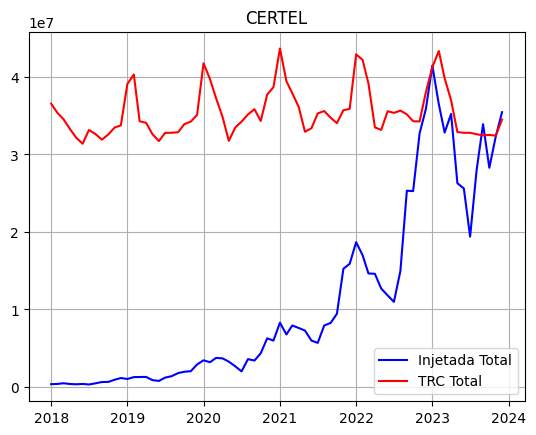

In [516]:
plt.plot(injetada_total, color='blue',label='Injetada Total')
plt.plot(trc_total, color='red', label='TRC Total')
plt.legend(loc='best')
plt.title('CERTEL')
plt.grid()

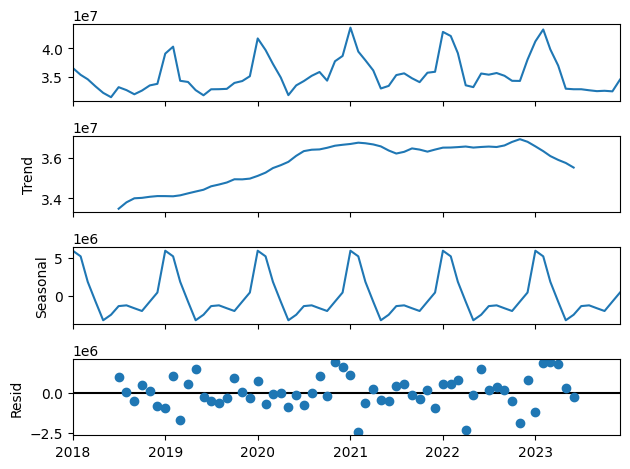

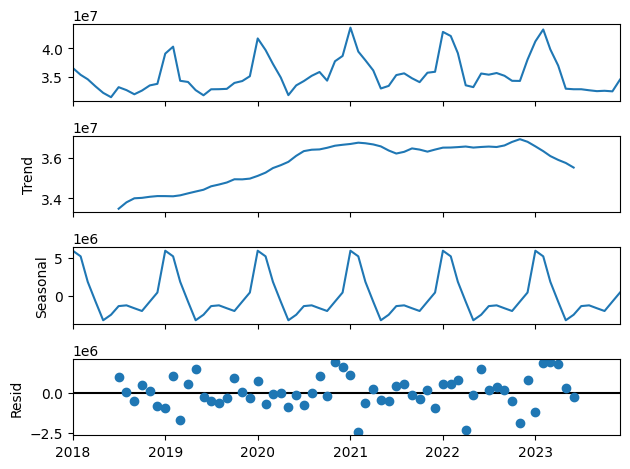

In [517]:
decompose_trc = seasonal_decompose(trc_total)
decompose_trc.plot()

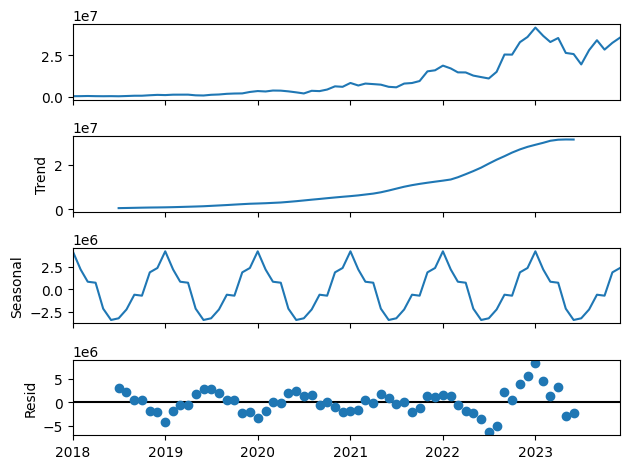

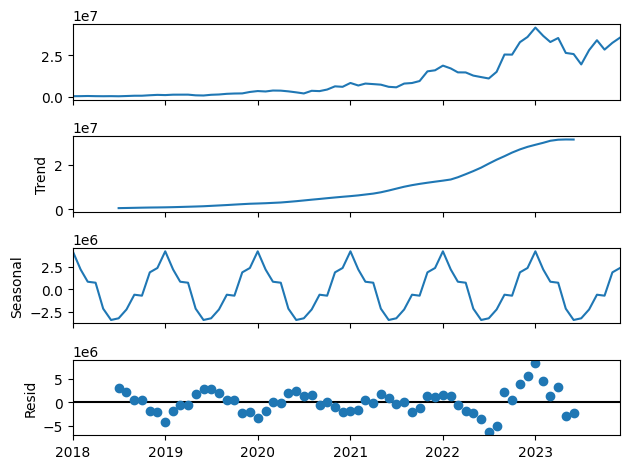

In [518]:
decompose_injetada = seasonal_decompose(injetada_total)
decompose_injetada.plot()

In [519]:
len(serie_temporal)

72

In [520]:
trc_train = pd.DataFrame(trc_total.iloc[:60, 0])
trc_test = pd.DataFrame(trc_total.iloc[60:, 0])
trc_test

,Consumo Ativo TUSD
MesReferencia,
2023-01-01,41249286.0
2023-02-01,43352706.0
2023-03-01,39827960.0
2023-04-01,36971162.0
2023-05-01,32883797.0
2023-06-01,32790629.0
2023-07-01,32790944.0
2023-08-01,32609752.0
2023-09-01,32454170.0


In [521]:
scaler = MinMaxScaler()

In [522]:
scaler.fit(trc_train)
scaled_train = scaler.transform(trc_train)
scaled_test = scaler.transform(trc_test)

In [523]:
scaled_train[:10]

array([[0.42012802],
       [0.32149056],
       [0.25773728],
       [0.15465192],
       [0.06238998],
       [0.        ],
       [0.14408316],
       [0.10179724],
       [0.04213427],
       [0.09511099]])

In [524]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [525]:
X,y = generator[0]
print(f'Dado: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Dado: 
[0.42012802 0.32149056 0.25773728]
Predict this y: 
 [[0.15465192]]


In [526]:
X.shape

(1, 3, 1)

In [527]:
# We do the same thing, but now instead for 12 months
n_input = 18
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [528]:
# define model
model = Sequential()
model.add(LSTM(125, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

c:\Users\Max\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [529]:
model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_37 (LSTM)                  │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

In [530]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50


c:\Users\Max\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0786
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0754
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1072
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0691  
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0469
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0437
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0606 
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0245
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0530
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0238
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0534
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0285  
Epoch 13/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0351
Epoch 14/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0287
Epoch 15/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0252  
Epoch 16/50
42/42 ━━━━━

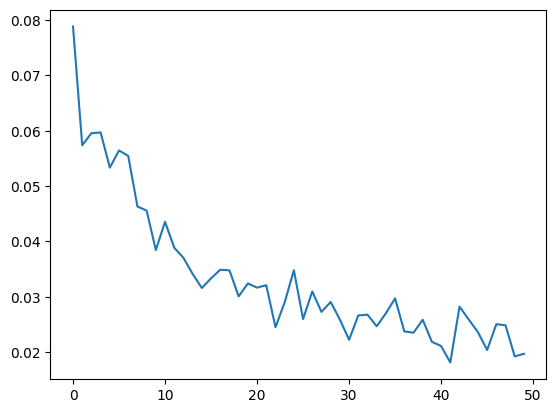

In [531]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [532]:
last_train_batch = scaled_train[-n_input:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


array([[0.77077425]], dtype=float32)

In [533]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(trc_test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [534]:
test_predictions

[array([0.77077425], dtype=float32),
 array([0.84815866], dtype=float32),
 array([0.6061715], dtype=float32),
 array([0.28951246], dtype=float32),
 array([0.21356142], dtype=float32),
 array([0.2562555], dtype=float32),
 array([0.33018494], dtype=float32),
 array([0.37413102], dtype=float32),
 array([0.43717444], dtype=float32),
 array([0.51011115], dtype=float32),
 array([0.6137312], dtype=float32),
 array([0.70256144], dtype=float32)]

In [535]:
trc_test.head()

,Consumo Ativo TUSD
MesReferencia,
2023-01-01,41249286.0
2023-02-01,43352706.0
2023-03-01,39827960.0
2023-04-01,36971162.0
2023-05-01,32883797.0


In [536]:
true_predictions = scaler.inverse_transform(test_predictions)

In [537]:
trc_test['Predictions'] = true_predictions

<Figure size 1400x600 with 0 Axes>

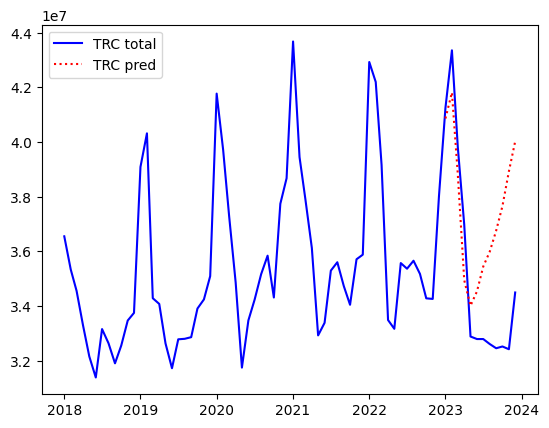

<Figure size 1400x600 with 0 Axes>

In [538]:
plt.plot(trc_total, color='blue', label='TRC total')
plt.plot(trc_test.loc[:, 'Predictions'], color='red', label='TRC pred', linestyle=':')
plt.legend(loc='best')
plt.figure(figsize=(14,6))

In [539]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

rmse = root_mean_squared_error(trc_test['Consumo Ativo TUSD'],trc_test['Predictions'])
mape = mean_absolute_percentage_error(trc_test['Consumo Ativo TUSD'],trc_test['Predictions'])
print(f'RMSE: {rmse}\nMAPE: {mape}')

RMSE: 3514025.9198276363
MAPE: 0.08734927351758531


Melhores rmse (1151172.6125657666) e mape (0.02674667107137064) em 125 neuronios, 50 epochs e 18 inputs

In [540]:
injetada_train = pd.DataFrame(injetada_total.iloc[:60, 0])
injetada_test = pd.DataFrame(injetada_total.iloc[60:, 0])
scaler.fit(injetada_train)
scaled_train = scaler.transform(injetada_train)
scaled_test = scaler.transform(injetada_test)

In [541]:
n_input = 18
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [542]:
model2 = Sequential()
model2.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')

c:\Users\Max\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [543]:
model.fit(generator,epochs=50)

Epoch 1/50
 1/42 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0174

c:\Users\Max\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0117
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032
Epoch 13/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018
Epoch 14/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024
Epoch 15/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019
Epoch 16/50
42/42 ━━

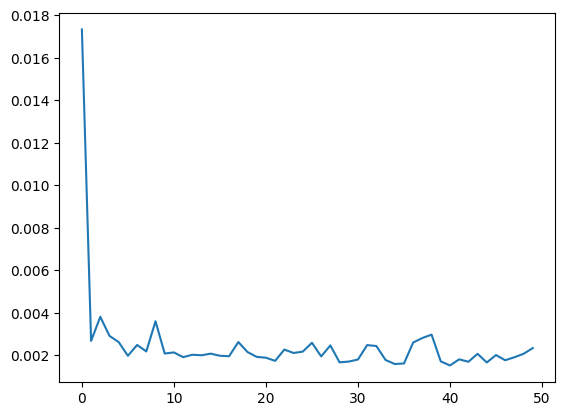

In [544]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [545]:
last_train_batch = scaled_train[-n_input:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.951944]], dtype=float32)

In [546]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(injetada_test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [547]:
true_predictions = scaler.inverse_transform(test_predictions)
injetada_test['Predictions'] = true_predictions

<Figure size 1400x600 with 0 Axes>

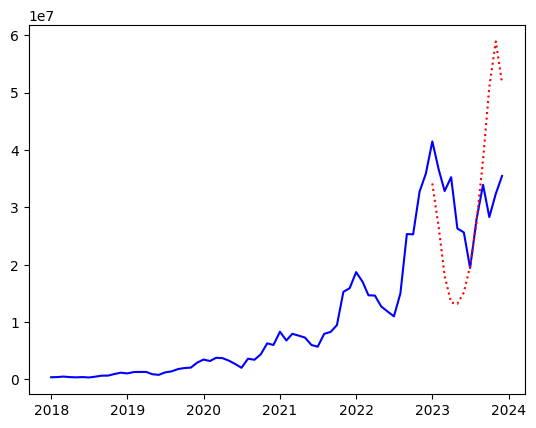

<Figure size 1400x600 with 0 Axes>

In [548]:
plt.plot(injetada_total, color='blue', label='Injetada total')
plt.plot(injetada_test.loc[:, 'Predictions'], color='red', label='Injetada pred', linestyle=':')
plt.figure(figsize=(14,6))

In [549]:
rmse = root_mean_squared_error(injetada_test['Energia Injetada'],trc_test['Predictions'])
mape = mean_absolute_percentage_error(injetada_test['Energia Injetada'],injetada_test['Predictions'])
print(f'RMSE: {rmse}\nMAPE: {mape}')

RMSE: 7566385.758619624
MAPE: 0.3898200114859685


<Figure size 1400x600 with 0 Axes>

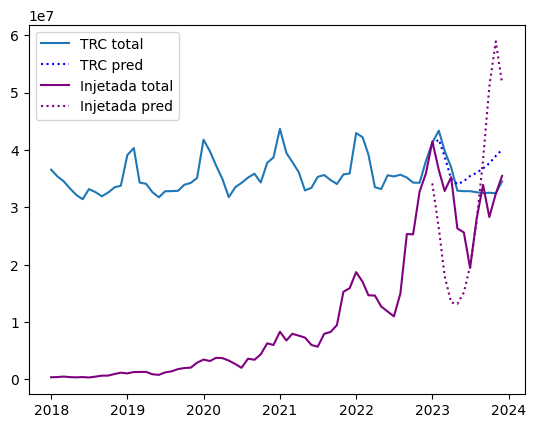

<Figure size 1400x600 with 0 Axes>

In [550]:
plt.plot(trc_total, label='TRC total')
plt.plot(trc_test.loc[:, 'Predictions'], color='blue', label='TRC pred', linestyle=':')
plt.plot(injetada_total, color='purple', label='Injetada total')
plt.plot(injetada_test.loc[:, 'Predictions'], color='purple', label='Injetada pred', linestyle=':')
plt.legend(loc='best')
plt.figure(figsize=(14,6))

In [551]:
rmse = root_mean_squared_error(trc_test['Consumo Ativo TUSD'],trc_test['Predictions'])
mape = mean_absolute_percentage_error(trc_test['Consumo Ativo TUSD'],trc_test['Predictions'])
print(f'RMSE TRC: {rmse}\nMAPE TRC: {mape}')
rmse = root_mean_squared_error(injetada_test['Energia Injetada'],trc_test['Predictions'])
mape = mean_absolute_percentage_error(injetada_test['Energia Injetada'],injetada_test['Predictions'])
print(f'RMSE inj: {rmse}\nMAPE inj: {mape}')

RMSE TRC: 3514025.9198276363
MAPE TRC: 0.08734927351758531
RMSE inj: 7566385.758619624
MAPE inj: 0.3898200114859685
